# Proyek Analisis Sentimen

 Notebook ini berisi analisis sentimen berdasarkan data ulasan dari aplikasi Brimo.

##

# Import Libraries  

Pada bagian ini, kita mengimpor pustaka (libraries) utama yang akan digunakan dalam analisis data, seperti pandas untuk pengolahan data, numpy untuk operasi numerik, serta matplotlib dan seaborn untuk visualisasi data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, GRU, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import requests
import csv
from io import StringIO
import tensorflow as tf

[nltk_data] Downloading package punkt to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##

# TQDM

TQDM digunakan untuk memberikan progress bar yang berguna ketika menjalankan operasi yang memerlukan waktu lama, sehingga pengguna dapat melihat progres pengerjaan secara real time.

In [2]:
%pip install tqdm

from tqdm import tqdm
tqdm.pandas()  # Integrasi tqdm dengan pandas

Note: you may need to restart the kernel to use updated packages.


# Membaca Data Ulasan / Load dataset

Data ulasan diimpor dari file CSV yang telah dihasilkan dari proses scraping. Fungsi DF digunakan untuk menampilkan data baris awal guna memastikan data sudah terbaca dengan benar. Dan sesuai dengan kriteria Memiliki jumlah data minimal 10.000 sampel data

In [3]:
# Menentukan path file CSV hasil scraping
file_path = r'D:\PROJECT\DBS DICODING\Belajar Pengembangan Machine Learning\sentimen\Proyek Analisis Sentimen\Dataset\ulasan_apk_brimo.csv'

# Membaca file CSV ke dalam DataFrame
data = pd.read_csv(file_path)

# Menampilkan DataFrame sebagai tabel
data

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,92845e58-a03e-4c82-abfd-e8133548983f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Login via scan fingerprint, malah muncul error...",5,701,2.79.0,2025-03-11 20:01:33,"Hai Sobat BRI, mohon maaf atas kendala yang di...",2025-03-16 15:32:05,2.79.0
1,b942ba12-2658-4f03-9f5a-b4a8d6c379b2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"BRImo menawarkan kemudahan transaksi, tampilan...",5,530,2.79.0,2025-03-12 14:05:04,"Hai Sobat BRI, mohon maaf atas ketidaknyamanan...",2025-03-12 14:30:05,2.79.0
2,ee7e5f6f-2265-4d7d-967b-2419ab4edd03,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Buat yg keganggu dikit2 update tak kasi tau, u...",5,1481,2.79.0,2025-03-13 21:10:57,Terima kasih atas ulasannya. Semoga aplikasi B...,2025-03-14 08:10:42,2.79.0
3,4a9c750d-606a-41ea-a4e5-a9724ba59c6c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tgl 6 maret 2025 sy diminta update..setelah up...,5,517,2.79.0,2025-03-08 06:54:07,"Hai Sobat BRI, mohon maaf atas ketidaknyamanan...",2025-03-10 20:10:59,2.79.0
4,076bfd33-6eb5-4f80-ac11-8c2e0c167861,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,BRImo lg error'..sinyal kuat dan stabil..mungk...,5,1,2.80.0,2025-03-20 13:56:54,"Hai Sobat BRI, mohon maaf atas ketidaknyamanan...",2025-03-21 09:50:54,2.80.0
...,...,...,...,...,...,...,...,...,...,...,...
29995,7992ea37-8214-42af-a8ee-9360958a8c40,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat membantu dalam melakukan transaksi.. ti...,5,1,2.69.0,2024-09-29 11:31:28,"Hai Sobat BRI, terima kasih sudah menggunakan ...",2024-09-29 13:01:34,2.69.0
29996,ffcbe19d-ff71-442c-a58a-a16b14269e1d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Fitur lengkap tidak ribet digunakan. Terima ka...,5,0,2.3.1,2021-04-25 01:40:53,"Terima kasih atas ulasannya, tingkatkan terus ...",2021-10-24 09:33:38,2.3.1
29997,b75d8c2d-b388-4499-9094-095716326b64,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Mantap ad promo tersembunyi,5,0,2.71.1,2024-10-30 19:50:55,"Hai, Sobat BRI. Terima kasih sudah menggunakan...",2025-01-26 16:19:29,2.71.1
29998,6494295d-412d-44cf-8fcf-bebf784eed8b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat puas dan sangat mudah untuk transaksi.,5,0,NaN,2025-01-30 13:24:34,"Hai, Sobat BRI. Terima kasih sudah menggunakan...",2025-01-30 14:18:40,NaN


# Ringkasan DataFrame

Fungsi info() memberikan ringkasan dari DataFrame, termasuk jumlah data, tipe data per kolom, dan penggunaan memori. Ini membantu dalam memahami struktur data sebelum diproses lebih lanjut.

In [5]:
# Tampilkan ringkasan dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  27587 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          29792 non-null  object
 9   repliedAt             29792 non-null  object
 10  appVersion            27587 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


##

# Mengecek Missing Data

Kita menghitung jumlah nilai yang hilang (NaN) di tiap kolom untuk mengetahui apakah ada kolom yang perlu penanganan khusus (misal, imputasi atau penghapusan).

In [6]:
# Menghitung dan menampilkan nilai NaN
missing_data = data.isna().sum()  # Menampilkan jumlah NaN per kolom
print(missing_data)

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2413
at                         0
replyContent             208
repliedAt                208
appVersion              2413
dtype: int64


# Menghapus Nilai NaN
Setelah mengecek missing data, langkah selanjutnya adalah menghapus baris-baris yang memiliki nilai NaN agar analisis data tidak terpengaruh oleh data yang tidak lengkap.

In [7]:
# Menghapus baris yang memiliki nilai NaN pada seluruh kolom
data.dropna(inplace=True)

# Cek kembali untuk memastikan tidak ada nilai NaN yang tersisa
print(data.isna().sum())

reviewId                0
userName                0
userImage               0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
repliedAt               0
appVersion              0
dtype: int64


Pada cell di atas, fungsi dropna() digunakan untuk menghapus semua baris yang memiliki nilai NaN. Hal ini memastikan bahwa dataset yang digunakan untuk analisis sentimen bersih dari data yang tidak lengkap, sehingga dapat meningkatkan kualitas dan keakuratan model yang akan dikembangkan.

# Data preparation

Menghapus missing value pada kolom content karena hanya kolom inilah yang akan digunakan untuk pelatihan model dan menghapus data yang duplikat.

In [8]:
# Menghapus missing value pada kolom 'content'
clean_data = data.dropna(subset=['content'])

# Menghapus data duplikat
clean_data = clean_data.drop_duplicates()

##

# Penghapusan Kolom yang Tidak Diperlukan

Kolom-kolom yang dianggap tidak relevan untuk analisis sentimen dihapus agar dataset lebih bersih dan memudahkan pemrosesan data.

In [10]:
# Hapus kolom pada DataFrame
df = data.drop(columns=['reviewId', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent',
                      'repliedAt', 'appVersion'])
print(df.columns)


Index(['userName', 'content', 'score', 'at'], dtype='object')


### Menampilkan DataFrame yang Sudah Dibersihkan

In [11]:
# Tampilkan Dataframe
df.head()

,userName,content,score,at
0,Pengguna Google,"Login via scan fingerprint, malah muncul error...",5,2025-03-11 20:01:33
1,Pengguna Google,"BRImo menawarkan kemudahan transaksi, tampilan...",5,2025-03-12 14:05:04
2,Pengguna Google,"Buat yg keganggu dikit2 update tak kasi tau, u...",5,2025-03-13 21:10:57
3,Pengguna Google,Tgl 6 maret 2025 sy diminta update..setelah up...,5,2025-03-08 06:54:07
4,Pengguna Google,BRImo lg error'..sinyal kuat dan stabil..mungk...,5,2025-03-20 13:56:54


### Informasi DataFrame Setelah Penghapusan Kolom

Memanggil kembali info() untuk memastikan struktur DataFrame dan mengetahui bahwa hanya kolom-kolom yang dibutuhkan (userName, content, score, at) yang tersisa.

In [12]:
# Tampilkan ringkasan informasi
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27385 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  27385 non-null  object
 1   content   27385 non-null  object
 2   score     27385 non-null  int64 
 3   at        27385 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


##

# Analisis Distribusi Nilai Score

Kode ini menghitung dan menampilkan distribusi nilai score dari ulasan, kemudian divisualisasikan dengan bar plot untuk memudahkan pemahaman persebaran rating ulasan.

score
5    27385
Name: count, dtype: int64


C:\Users\Sion Pardosi\AppData\Local\Temp\ipykernel_45532\2771258360.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts.index, y=score_counts.values, palette="viridis")


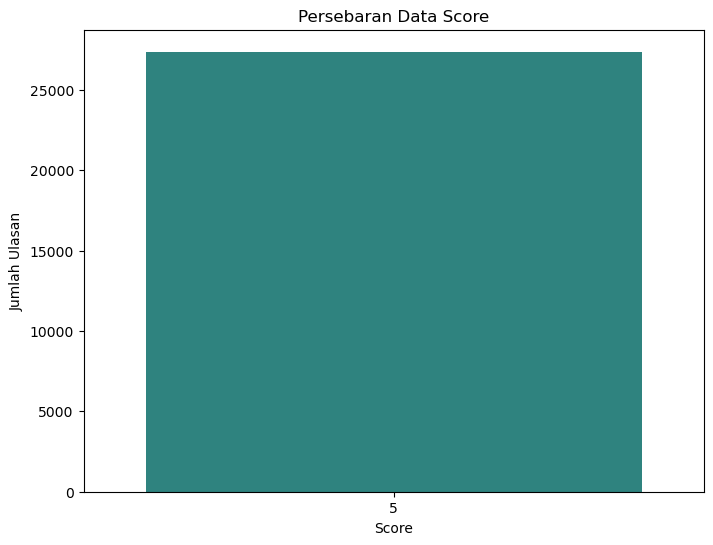

In [13]:
# Menghitung frekuensi setiap nilai score (1-5)
score_counts = df['score'].value_counts()
print(score_counts)

# Visualisasi distribusi score menggunakan bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=score_counts.index, y=score_counts.values, palette="viridis")
plt.title('Persebaran Data Score')
plt.xlabel('Score')
plt.ylabel('Jumlah Ulasan')
plt.show()

##

# Preprocessing Data: Menghapus Duplikat

Duplikat dihapus dengan basis kolom 'content' untuk memastikan bahwa setiap ulasan dihitung satu kali. Hal ini penting agar analisis tidak bias akibat data yang berulang.

In [14]:
# Menghapus duplikat berdasarkan kolom 'content' agar setiap ulasan unik
df.drop_duplicates(subset='content', keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26060 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  26060 non-null  object
 1   content   26060 non-null  object
 2   score     26060 non-null  int64 
 3   at        26060 non-null  object
dtypes: int64(1), object(3)
memory usage: 1018.0+ KB


##

# WordCloud Sebelum Preprocessing

WordCloud dibuat untuk memvisualisasikan kata-kata yang sering muncul dalam ulasan sebelum dilakukan preprocessing lebih lanjut. Ini membantu mengidentifikasi kata-kata umum dan potensi noise dalam data.

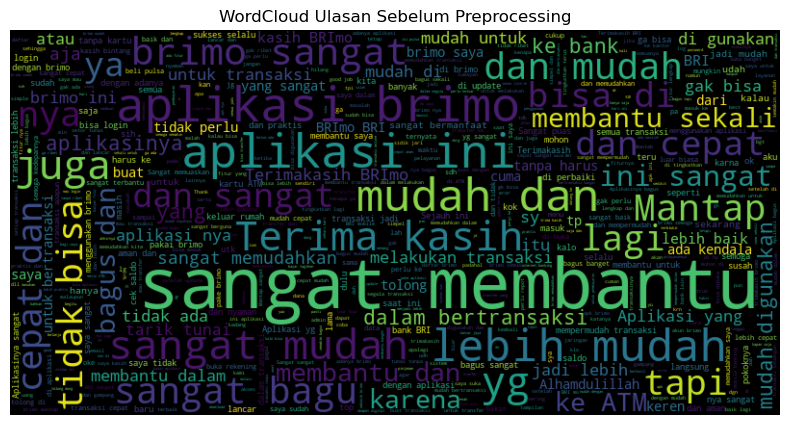

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Pastikan tidak ada nilai NaN pada kolom 'content'
df['content'] = df['content'].fillna('')

# Menggabungkan semua teks ulasan
text = ' '.join(df['content'].astype(str).tolist())

# Menentukan stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp'])

# Membuat objek WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", max_words=500, width=800, height=400)
wc.generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud Ulasan Sebelum Preprocessing")
plt.show()

##

# Visualisasi Frekuensi Kata

Visualisasi frekuensi kata ini memperlihatkan 10 kata paling umum dari ulasan. Dengan menggunakan bar plot, kita dapat dengan mudah melihat distribusi kata-kata yang dominan sebelum data diproses lebih lanjut dalam analisis sentimen.

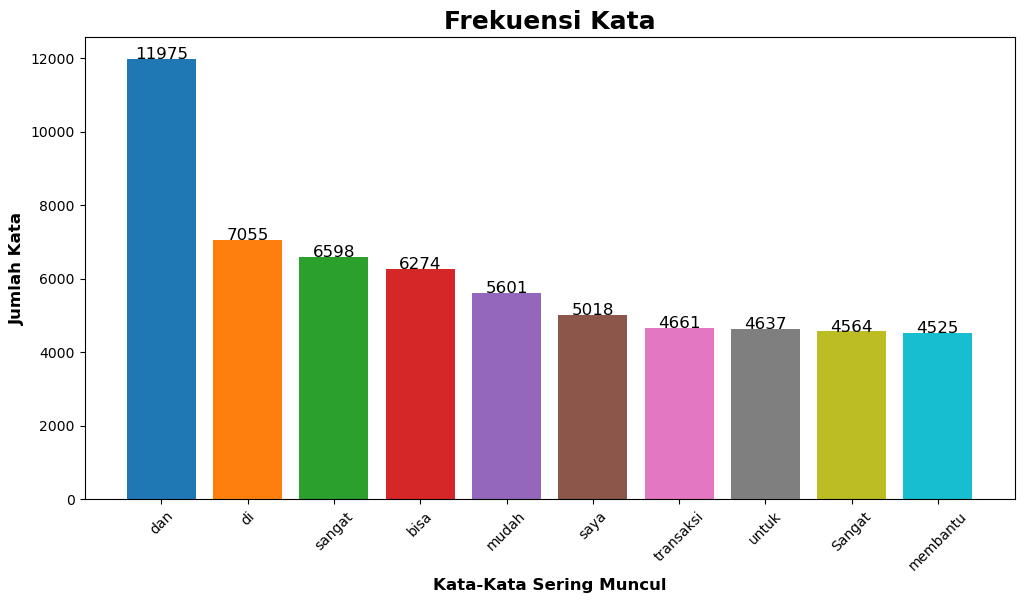

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# Menggabungkan seluruh teks dari kolom 'content'
text = " ".join(df["content"].astype(str))

# Tokenisasi teks berdasarkan spasi
tokens = text.split()

# Menghitung frekuensi setiap kata
word_counts = Counter(tokens)

# Mengambil 10 kata yang paling sering muncul
top_words = word_counts.most_common(10)

# Memisahkan kata dan jumlahnya
words, counts = zip(*top_words)

# Mendefinisikan palet warna
colors = plt.cm.tab10(range(len(words)))

# Membuat bar plot untuk frekuensi kata
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color=colors)
plt.xlabel("Kata-Kata Sering Muncul", fontsize=12, fontweight='bold')
plt.ylabel("Jumlah Kata", fontsize=12, fontweight='bold')
plt.title("Frekuensi Kata", fontsize=18, fontweight='bold')
plt.xticks(rotation=45)

# Menambahkan nilai di atas setiap bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 1, str(count), fontsize=12, color='black', ha='center')

plt.show()

##

# PREPROCESS TEXT: Pembersihan Teks

##

# NLTK

Instalasi library NLTK diperlukan untuk melakukan preprocessing teks, seperti tokenisasi, stopwords, dan stemming jika diperlukan.

In [17]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


Setelah menginstall NLTK, kita mengimpor modul-modul yang dibutuhkan serta mendownload resource seperti tokenizers, stopwords, dan wordnet untuk mendukung preprocessing teks.

In [18]:
import string
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Fungsi Preprocessing Teks

In [19]:
# Mendefinisikan fungsi-fungsi untuk preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [20]:
def preprocess_text(text):
    """
    Membersihkan teks dengan menghapus URL, mengubah ke lowercase, menghapus mention dan hashtag,
    serta menghapus karakter spesial, tanda baca, dan angka.
    """
    # Hapus URL
    text = re.sub(r'https?\S+', ' ', text, flags=re.IGNORECASE)
    
    # Ubah ke huruf kecil
    text = text.lower()
    
    # Hapus mention dan hashtag
    text = re.sub(r'[@#]\S+', ' ', text)
    
    # Hapus karakter spesial dan tanda baca menggunakan modul string
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), ' ', text)
    
    # Hapus angka (jika diperlukan)
    text = re.sub(r'\d+', ' ', text)
    
    # Hapus extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Mendefinisikan fungsi untuk mengubah slangwords menjadi bentuk baku secara manual.

In [21]:
# Mendefinisikan fungsi untuk slangwords

slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

Mendefinisikan clean_df sebagai dataframe yang sudah bersih.

In [22]:
# Menampilkan dataset yang belum dibersihkan
clean_df = clean_data
clean_df.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,92845e58-a03e-4c82-abfd-e8133548983f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Login via scan fingerprint, malah muncul error...",5,701,2.79.0,2025-03-11 20:01:33,"Hai Sobat BRI, mohon maaf atas kendala yang di...",2025-03-16 15:32:05,2.79.0


# Terapkan Preprocessing ke Kolom Teks

Kolom content diisi ke dalam kolom baru text_Clean setelah melalui proses pembersihan. Proses ini penting untuk menyiapkan data ulasan sebelum dilakukan ekstraksi fitur dan pelatihan model analisis sentimen.

In [24]:
# Pastikan kolom 'content' tidak memiliki nilai NaN
df['content'] = df['content'].fillna('')

# Terapkan fungsi preprocess_text dengan integrasi progress bar dari tqdm
df['text_Clean'] = df['content'].progress_apply(preprocess_text)
df

  7%|▋         | 1727/26060 [00:00<00:01, 17266.06it/s]

100%|██████████| 26060/26060 [00:01<00:00, 25057.58it/s]


,userName,content,score,at,text_Clean
0,Pengguna Google,"Login via scan fingerprint, malah muncul error...",5,2025-03-11 20:01:33,login via scan fingerprint malah muncul error ...
1,Pengguna Google,"BRImo menawarkan kemudahan transaksi, tampilan...",5,2025-03-12 14:05:04,brimo menawarkan kemudahan transaksi tampilan ...
2,Pengguna Google,"Buat yg keganggu dikit2 update tak kasi tau, u...",5,2025-03-13 21:10:57,buat yg keganggu dikit update tak kasi tau upd...
3,Pengguna Google,Tgl 6 maret 2025 sy diminta update..setelah up...,5,2025-03-08 06:54:07,tgl maret sy diminta update setelah update mun...
4,Pengguna Google,BRImo lg error'..sinyal kuat dan stabil..mungk...,5,2025-03-20 13:56:54,brimo lg error sinyal kuat dan stabil mungkin ...
...,...,...,...,...,...
29994,Pengguna Google,Saya suka aplikasi ini kalau lagi ada saldonya...,5,2023-04-14 11:19:03,saya suka aplikasi ini kalau lagi ada saldonya...
29995,Pengguna Google,sangat membantu dalam melakukan transaksi.. ti...,5,2024-09-29 11:31:28,sangat membantu dalam melakukan transaksi tida...
29996,Pengguna Google,Fitur lengkap tidak ribet digunakan. Terima ka...,5,2021-04-25 01:40:53,fitur lengkap tidak ribet digunakan terima kas...
29997,Pengguna Google,Mantap ad promo tersembunyi,5,2024-10-30 19:50:55,mantap ad promo tersembunyi


# Membaca Kamus Slang

Pada bagian ini, kita membaca kamus slang dari file Excel dan menyusunnya menjadi dictionary. Fungsi ganti_slang akan mengganti setiap kata slang dalam teks dengan padanan kata bakunya.

In [26]:
# Membaca kamus slang dari file Excel
kamus_slang = pd.read_excel(r'D:\PROJECT\DBS DICODING\Belajar Pengembangan Machine Learning\sentimen\Proyek Analisis Sentimen\Dataset\kamuskatabaku.xlsx')

# Menyusun kamus slang sebagai dictionary: slang -> kata baku
slang_dict = dict(zip(kamus_slang['tidak_baku'], kamus_slang['kata_baku']))

# Fungsi untuk mengganti slang dengan kata baku
def ganti_slang(teks):
    return ' '.join([slang_dict.get(kata, kata) for kata in teks.split()])

# Contoh penerapan fungsi pada teks
print(ganti_slang("saya nggak tau, tapi sya ngerti"))


saya tidak tau, tapi saya mengerti


# Menerapkan Normalisasi Slang pada Data

Fungsi ganti_slang diterapkan ke kolom text_Clean (hasil preprocessing awal) untuk menghasilkan kolom baru text_Normalization yang berisi teks dengan kata-kata slang telah diganti ke bentuk baku.

In [27]:
# Menerapkan fungsi ganti_slang pada kolom 'text_StopWord'
df['text_Normalization'] = df['text_Clean'].progress_apply(ganti_slang)
df.head()

 36%|███▌      | 9259/26060 [00:00<00:00, 92050.42it/s]

100%|██████████| 26060/26060 [00:00<00:00, 103164.06it/s]


,userName,content,score,at,text_Clean,text_Normalization
0,Pengguna Google,"Login via scan fingerprint, malah muncul error...",5,2025-03-11 20:01:33,login via scan fingerprint malah muncul error ...,login via scan fingerprint malah muncul error ...
1,Pengguna Google,"BRImo menawarkan kemudahan transaksi, tampilan...",5,2025-03-12 14:05:04,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...
2,Pengguna Google,"Buat yg keganggu dikit2 update tak kasi tau, u...",5,2025-03-13 21:10:57,buat yg keganggu dikit update tak kasi tau upd...,buat yang keganggu dikit update tak kasih tau ...
3,Pengguna Google,Tgl 6 maret 2025 sy diminta update..setelah up...,5,2025-03-08 06:54:07,tgl maret sy diminta update setelah update mun...,tanggal maret saya diminta update setelah upda...
4,Pengguna Google,BRImo lg error'..sinyal kuat dan stabil..mungk...,5,2025-03-20 13:56:54,brimo lg error sinyal kuat dan stabil mungkin ...,brimo lagi error sinyal kuat dan stabil mungki...


# Mengunduh Stopwords dengan NLTK

Stopwords untuk bahasa Indonesia diunduh menggunakan NLTK, sehingga kita dapat menghapus kata-kata umum yang tidak memberikan nilai informasi pada analisis.

In [28]:
# Import pustaka nltk dari modul corpus dan download stopwords
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Sion
[nltk_data]     Pardosi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Penghapusan Stopwords

Pada tahap ini, stopwords dihapus dari kolom text_Normalization. Hasilnya disimpan dalam kolom baru text_StopWord untuk meminimalisasi noise dan meningkatkan kualitas fitur teks.

In [29]:
# Hapus kata-kata umum (stopwords) menggunakan NLTK
stop = stopwords.words('indonesian')
df['text_StopWord'] = df['text_Normalization'].progress_apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop])
)
df.head()

  1%|          | 164/26060 [00:00<00:15, 1628.01it/s]

100%|██████████| 26060/26060 [00:06<00:00, 3871.56it/s]


,userName,content,score,at,text_Clean,text_Normalization,text_StopWord
0,Pengguna Google,"Login via scan fingerprint, malah muncul error...",5,2025-03-11 20:01:33,login via scan fingerprint malah muncul error ...,login via scan fingerprint malah muncul error ...,login via scan fingerprint muncul error transa...
1,Pengguna Google,"BRImo menawarkan kemudahan transaksi, tampilan...",5,2025-03-12 14:05:04,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...
2,Pengguna Google,"Buat yg keganggu dikit2 update tak kasi tau, u...",5,2025-03-13 21:10:57,buat yg keganggu dikit update tak kasi tau upd...,buat yang keganggu dikit update tak kasih tau ...,keganggu dikit update kasih tau update perbaik...
3,Pengguna Google,Tgl 6 maret 2025 sy diminta update..setelah up...,5,2025-03-08 06:54:07,tgl maret sy diminta update setelah update mun...,tanggal maret saya diminta update setelah upda...,tanggal maret update update muncul fitur menon...
4,Pengguna Google,BRImo lg error'..sinyal kuat dan stabil..mungk...,5,2025-03-20 13:56:54,brimo lg error sinyal kuat dan stabil mungkin ...,brimo lagi error sinyal kuat dan stabil mungki...,brimo error sinyal kuat stabil pengaruh cuaca ...


# Tokenisasi Teks dengan RegexpTokenizer / word_tokenize

Di sini kita menggunakan RegexpTokenizer dengan pola raw string (r'\w+') untuk melakukan tokenisasi pada teks. Hal ini memecah teks menjadi token berdasarkan karakter alfanumerik dan menghindari peringatan syntax terkait escape sequence.

In [30]:
# Mengimpor modul tokenisasi dan melakukan tokenisasi teks
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer

# Menggunakan raw string untuk pola regex agar tidak menghasilkan SyntaxWarning
regexp = RegexpTokenizer(r'\w+')

# Menerapkan tokenisasi pada kolom text_StopWord
df['text_Tokenization'] = df['text_StopWord'].progress_apply(regexp.tokenize)
df.head()

100%|██████████| 26060/26060 [00:00<00:00, 112906.64it/s]


,userName,content,score,at,text_Clean,text_Normalization,text_StopWord,text_Tokenization
0,Pengguna Google,"Login via scan fingerprint, malah muncul error...",5,2025-03-11 20:01:33,login via scan fingerprint malah muncul error ...,login via scan fingerprint malah muncul error ...,login via scan fingerprint muncul error transa...,"[login, via, scan, fingerprint, muncul, error,..."
1,Pengguna Google,"BRImo menawarkan kemudahan transaksi, tampilan...",5,2025-03-12 14:05:04,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...,"[brimo, menawarkan, kemudahan, transaksi, tamp..."
2,Pengguna Google,"Buat yg keganggu dikit2 update tak kasi tau, u...",5,2025-03-13 21:10:57,buat yg keganggu dikit update tak kasi tau upd...,buat yang keganggu dikit update tak kasih tau ...,keganggu dikit update kasih tau update perbaik...,"[keganggu, dikit, update, kasih, tau, update, ..."
3,Pengguna Google,Tgl 6 maret 2025 sy diminta update..setelah up...,5,2025-03-08 06:54:07,tgl maret sy diminta update setelah update mun...,tanggal maret saya diminta update setelah upda...,tanggal maret update update muncul fitur menon...,"[tanggal, maret, update, update, muncul, fitur..."
4,Pengguna Google,BRImo lg error'..sinyal kuat dan stabil..mungk...,5,2025-03-20 13:56:54,brimo lg error sinyal kuat dan stabil mungkin ...,brimo lagi error sinyal kuat dan stabil mungki...,brimo error sinyal kuat stabil pengaruh cuaca ...,"[brimo, error, sinyal, kuat, stabil, pengaruh,..."


##

# Sastrawi

Baris kode ini menginstall package Sastrawi yang digunakan untuk proses stemming dalam bahasa Indonesia. Pastikan untuk me-restart kernel jika diperlukan setelah instalasi.

In [31]:
%pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.


# Import dan Inisialisasi Sastrawi

Di sini, kita mengimpor modul Stemmer dari Sastrawi dan menginisialisasi stemmer dengan menggunakan StemmerFactory. Stemmer ini akan digunakan untuk mengubah kata ke bentuk dasarnya.

In [32]:
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Melakukan Stemming pada Token Teks

Kode ini menerapkan stemming pada setiap token yang dihasilkan dari tahap tokenisasi. Hasil stemming disimpan pada kolom baru text_Stemmindo sehingga setiap token diubah ke bentuk dasar (stem).

In [33]:
# Melakukan stemming dari tokens
df['text_Stemmindo'] = df['text_Tokenization'].progress_apply(lambda x: [stemmer.stem(y) for y in x])

  0%|          | 0/26060 [00:00<?, ?it/s]

100%|██████████| 26060/26060 [35:27<00:00, 12.25it/s]  


# Menampilkan Hasil DataFrame

Cell ini digunakan untuk menampilkan tampilan awal dari DataFrame sehingga dapat diverifikasi bahwa kolom text_Stemmindo telah terisi dengan token hasil stemming dari setiap baris data.

In [34]:
# Menampilkan beberapa baris pertama DataFrame untuk memastikan proses stemming telah berjalan dengan benar
df.head(20)

,userName,content,score,at,text_Clean,text_Normalization,text_StopWord,text_Tokenization,text_Stemmindo
0,Pengguna Google,"Login via scan fingerprint, malah muncul error...",5,2025-03-11 20:01:33,login via scan fingerprint malah muncul error ...,login via scan fingerprint malah muncul error ...,login via scan fingerprint muncul error transa...,"[login, via, scan, fingerprint, muncul, error,...","[login, via, scan, fingerprint, muncul, error,..."
1,Pengguna Google,"BRImo menawarkan kemudahan transaksi, tampilan...",5,2025-03-12 14:05:04,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...,"[brimo, menawarkan, kemudahan, transaksi, tamp...","[brimo, tawar, mudah, transaksi, tampil, intui..."
2,Pengguna Google,"Buat yg keganggu dikit2 update tak kasi tau, u...",5,2025-03-13 21:10:57,buat yg keganggu dikit update tak kasi tau upd...,buat yang keganggu dikit update tak kasih tau ...,keganggu dikit update kasih tau update perbaik...,"[keganggu, dikit, update, kasih, tau, update, ...","[ganggu, dikit, update, kasih, tau, update, ba..."
3,Pengguna Google,Tgl 6 maret 2025 sy diminta update..setelah up...,5,2025-03-08 06:54:07,tgl maret sy diminta update setelah update mun...,tanggal maret saya diminta update setelah upda...,tanggal maret update update muncul fitur menon...,"[tanggal, maret, update, update, muncul, fitur...","[tanggal, maret, update, update, muncul, fitur..."
4,Pengguna Google,BRImo lg error'..sinyal kuat dan stabil..mungk...,5,2025-03-20 13:56:54,brimo lg error sinyal kuat dan stabil mungkin ...,brimo lagi error sinyal kuat dan stabil mungki...,brimo error sinyal kuat stabil pengaruh cuaca ...,"[brimo, error, sinyal, kuat, stabil, pengaruh,...","[brimo, error, sinyal, kuat, stabil, pengaruh,..."
5,Pengguna Google,"Di perangkat saya, terkadang BRImo tidak meres...",5,2025-03-05 12:20:23,di perangkat saya terkadang brimo tidak meresp...,di perangkat saya terkadang brimo tidak meresp...,perangkat terkadang brimo merespons aplikasi m...,"[perangkat, terkadang, brimo, merespons, aplik...","[perangkat, terkadang, brimo, respons, aplikas..."
6,Pengguna Google,"Min...kenapa tidak bisa masuk brimo, padahal j...",5,2025-02-23 05:29:53,min kenapa tidak bisa masuk brimo padahal jari...,min kenapa tidak bisa masuk brimo padahal jari...,min masuk brimo jaringan stabil user id passwo...,"[min, masuk, brimo, jaringan, stabil, user, id...","[min, masuk, brimo, jaring, stabil, user, id, ..."
7,Pengguna Google,"Tiba2 tidak bisa akses brimo, karena password ...",5,2025-03-18 08:41:37,tiba tidak bisa akses brimo karena password sa...,tiba tidak bisa akses brimo karena password sa...,akses brimo password salah ngapa hapus aplikas...,"[akses, brimo, password, salah, ngapa, hapus, ...","[akses, brimo, password, salah, ngapa, hapus, ..."
8,Pengguna Google,"rawan security nya, menurut saya. Lapisan pass...",5,2025-02-18 04:07:09,rawan security nya menurut saya lapisan passwo...,rawan security ya menurut saya lapisan passwor...,rawan security ya lapisan password baiknya dit...,"[rawan, security, ya, lapisan, password, baikn...","[rawan, security, ya, lapis, password, baik, t..."
9,Pengguna Google,"Memudahkan nasabah, mungkin sedikit masukan ka...",5,2025-01-31 14:14:51,memudahkan nasabah mungkin sedikit masukan kal...,memudahkan nasabah mungkin sedikit masukan kal...,memudahkan nasabah masukan daftar mutasi pence...,"[memudahkan, nasabah, masukan, daftar, mutasi,...","[mudah, nasabah, masuk, daftar, mutasi, pencet..."


# Menggabungkan Hasil Stemming Menjadi String

Tahap ini menggabungkan token-token yang telah distemming menjadi satu string, dengan menyaring token yang panjangnya lebih dari 3 karakter. Hal ini membantu mengurangi noise dari token-token yang terlalu pendek.

In [35]:
# Melakukan string dari stemming
df['text_String'] = df['text_Stemmindo'].progress_apply(lambda x: ' '.join([item for item in x if len(item)>3]))
df.head(20)

100%|██████████| 26060/26060 [00:00<00:00, 566686.17it/s]


,userName,content,score,at,text_Clean,text_Normalization,text_StopWord,text_Tokenization,text_Stemmindo,text_String
0,Pengguna Google,"Login via scan fingerprint, malah muncul error...",5,2025-03-11 20:01:33,login via scan fingerprint malah muncul error ...,login via scan fingerprint malah muncul error ...,login via scan fingerprint muncul error transa...,"[login, via, scan, fingerprint, muncul, error,...","[login, via, scan, fingerprint, muncul, error,...",login scan fingerprint muncul error transaksi ...
1,Pengguna Google,"BRImo menawarkan kemudahan transaksi, tampilan...",5,2025-03-12 14:05:04,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...,"[brimo, menawarkan, kemudahan, transaksi, tamp...","[brimo, tawar, mudah, transaksi, tampil, intui...",brimo tawar mudah transaksi tampil intuitif ak...
2,Pengguna Google,"Buat yg keganggu dikit2 update tak kasi tau, u...",5,2025-03-13 21:10:57,buat yg keganggu dikit update tak kasi tau upd...,buat yang keganggu dikit update tak kasih tau ...,keganggu dikit update kasih tau update perbaik...,"[keganggu, dikit, update, kasih, tau, update, ...","[ganggu, dikit, update, kasih, tau, update, ba...",ganggu dikit update kasih update baik celah le...
3,Pengguna Google,Tgl 6 maret 2025 sy diminta update..setelah up...,5,2025-03-08 06:54:07,tgl maret sy diminta update setelah update mun...,tanggal maret saya diminta update setelah upda...,tanggal maret update update muncul fitur menon...,"[tanggal, maret, update, update, muncul, fitur...","[tanggal, maret, update, update, muncul, fitur...",tanggal maret update update muncul fitur nonak...
4,Pengguna Google,BRImo lg error'..sinyal kuat dan stabil..mungk...,5,2025-03-20 13:56:54,brimo lg error sinyal kuat dan stabil mungkin ...,brimo lagi error sinyal kuat dan stabil mungki...,brimo error sinyal kuat stabil pengaruh cuaca ...,"[brimo, error, sinyal, kuat, stabil, pengaruh,...","[brimo, error, sinyal, kuat, stabil, pengaruh,...",brimo error sinyal kuat stabil pengaruh cuaca ...
5,Pengguna Google,"Di perangkat saya, terkadang BRImo tidak meres...",5,2025-03-05 12:20:23,di perangkat saya terkadang brimo tidak meresp...,di perangkat saya terkadang brimo tidak meresp...,perangkat terkadang brimo merespons aplikasi m...,"[perangkat, terkadang, brimo, merespons, aplik...","[perangkat, terkadang, brimo, respons, aplikas...",perangkat terkadang brimo respons aplikasi mod...
6,Pengguna Google,"Min...kenapa tidak bisa masuk brimo, padahal j...",5,2025-02-23 05:29:53,min kenapa tidak bisa masuk brimo padahal jari...,min kenapa tidak bisa masuk brimo padahal jari...,min masuk brimo jaringan stabil user id passwo...,"[min, masuk, brimo, jaringan, stabil, user, id...","[min, masuk, brimo, jaring, stabil, user, id, ...",masuk brimo jaring stabil user password telah ...
7,Pengguna Google,"Tiba2 tidak bisa akses brimo, karena password ...",5,2025-03-18 08:41:37,tiba tidak bisa akses brimo karena password sa...,tiba tidak bisa akses brimo karena password sa...,akses brimo password salah ngapa hapus aplikas...,"[akses, brimo, password, salah, ngapa, hapus, ...","[akses, brimo, password, salah, ngapa, hapus, ...",akses brimo password salah ngapa hapus aplikas...
8,Pengguna Google,"rawan security nya, menurut saya. Lapisan pass...",5,2025-02-18 04:07:09,rawan security nya menurut saya lapisan passwo...,rawan security ya menurut saya lapisan passwor...,rawan security ya lapisan password baiknya dit...,"[rawan, security, ya, lapisan, password, baikn...","[rawan, security, ya, lapis, password, baik, t...",rawan security lapis password baik tambah tran...
9,Pengguna Google,"Memudahkan nasabah, mungkin sedikit masukan ka...",5,2025-01-31 14:14:51,memudahkan nasabah mungkin sedikit masukan kal...,memudahkan nasabah mungkin sedikit masukan kal...,memudahkan nasabah masukan daftar mutasi pence...,"[memudahkan, nasabah, masukan, daftar, mutasi,...","[mudah, nasabah, masuk, dafta

##

# Mengunduh Lexicon Positif dan Negatif dari GitHub

In [46]:
# Lexicon Positif
lexicon_positive = {}
url_positive = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
response = requests.get(url_positive)
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        if row:  # pastikan baris tidak kosong
            lexicon_positive[row[0]] = int(row[1])
else:
    print("Gagal mengunduh lexicon positif dari GitHub.")

# Lexicon Negatif
lexicon_negative = {}
url_negative = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'
response = requests.get(url_negative)
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        if row:
            lexicon_negative[row[0]] = int(row[1])
else:
    print("Gagal mengunduh lexicon negatif dari GitHub.")


# Mendefinisikan Fungsi untuk Menghitung Polaritas Sentimen

Kode di atas membuat kolom label_num secara vectorized dengan memberikan label numerik berdasarkan skor ulasan: 1 untuk skor di atas 3 (positif), 0 untuk skor sama dengan 3 (netral), dan -1 untuk skor di bawah 3 (negatif).

In [37]:
def sentiment_analysis_lexicon_indonesia(token_list):
    """
    Menghitung skor sentimen berdasarkan lexicon.
    Parameter:
      token_list: List of tokens (kata-kata hasil tokenisasi)
    Mengembalikan:
      score (int): Skor sentimen kumulatif
      polarity (str): Label polaritas ('positive', 'neutral', 'negative')
    """
    score = 0
    
    # Menambahkan skor untuk kata-kata positif
    for word in token_list:
        if word in lexicon_positive:
            score += lexicon_positive[word]
    
    # Menambahkan (atau mengurangi) skor untuk kata-kata negatif
    for word in token_list:
        if word in lexicon_negative:
            score += lexicon_negative[word]
    
    # Menentukan label polaritas berdasarkan skor
    if score >= 0:
        polarity = 'positive'
    elif score <= -7:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    
    return score, polarity


# Melakukan Pelabelan Data: Menghitung Polaritas Sentimen

In [41]:
# Pastikan kolom yang digunakan adalah yang berisi token, misalnya 'text_Stemmindo'
results = df['text_Stemmindo'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))  # Memisahkan skor dan label polaritas
df['polarity_score'] = results[0]
df['polarity'] = results[1]

# Menampilkan distribusi label polaritas
print(df['polarity'].value_counts())


polarity
positive    18828
neutral      5161
negative     2071
Name: count, dtype: int64


## 

# Data understanding

### Menampilkan distribusi polarity_score dengan histogram.

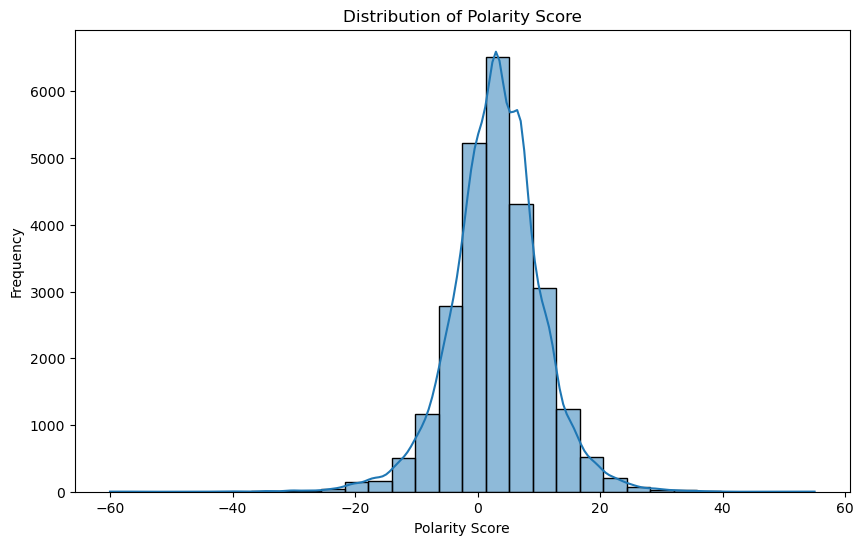

In [47]:
plt.figure(figsize=(10, 6))
sns.histplot(df['polarity_score'], bins=30, kde=True)
plt.title('Distribution of Polarity Score')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()


### Menampilkan diagram lingkaran untuk memudahkan visualisasi pembagian dataset.

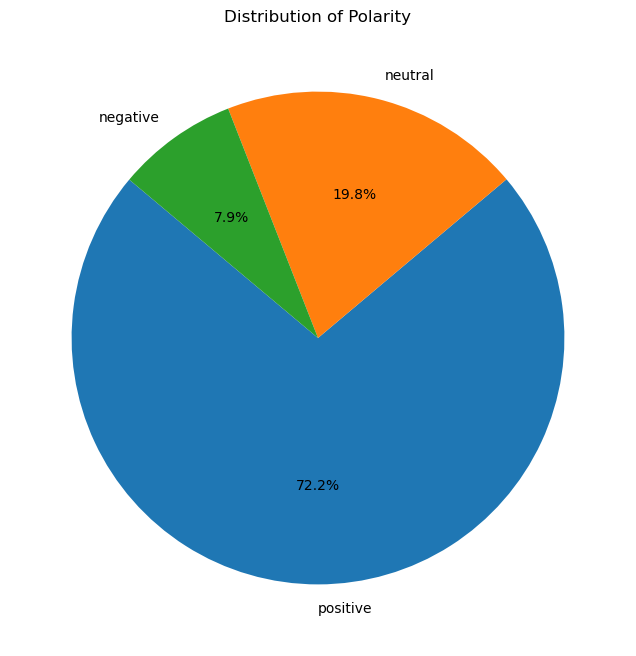

In [49]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = df['polarity'].value_counts()

# Menampilkan diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Polarity')
plt.show()


# Melihat Informasi DataFrame

Memeriksa informasi DataFrame penting untuk mengetahui apakah semua kolom sudah sesuai dengan yang diharapkan setelah tahap preprocessing.

In [55]:
# melihat informasi dari dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26060 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   userName            26060 non-null  object
 1   content             26060 non-null  object
 2   score               26060 non-null  int64 
 3   at                  26060 non-null  object
 4   text_Clean          26060 non-null  object
 5   text_Normalization  26060 non-null  object
 6   text_StopWord       26060 non-null  object
 7   text_Tokenization   26060 non-null  object
 8   text_Stemmindo      26060 non-null  object
 9   text_String         26060 non-null  object
 10  polarity_score      26060 non-null  int64 
 11  polarity            26060 non-null  object
dtypes: int64(2), object(10)
memory usage: 2.6+ MB


##

# Menyimpan Hasil Preprocessing ke File CSV

Data yang sudah diproses disimpan ke dalam file CSV sehingga dapat digunakan untuk analisis lanjutan 

In [57]:
# Menyimpan DataFrame hasil preprocessing ke file CSV
output_path = r'D:\PROJECT\DBS DICODING\Belajar Pengembangan Machine Learning\sentimen\Proyek Analisis Sentimen\Dataset\hasil_PreProcessing_apk_brimo.csv'
df.to_csv(output_path, index=False)


##

# Membaca Kembali File Hasil Preprocessing

Langkah ini memastikan file CSV yang telah disimpan dapat dibaca kembali dengan benar, sehingga kita dapat melakukan verifikasi atau analisis lebih lanjut.

In [58]:
# Membaca file CSV hasil preprocessing ke dalam DataFrame
df = pd.read_csv(output_path)

In [59]:
df.head(20)

,userName,content,score,at,text_Clean,text_Normalization,text_StopWord,text_Tokenization,text_Stemmindo,text_String,polarity_score,polarity
0,Pengguna Google,"Login via scan fingerprint, malah muncul error...",5,2025-03-11 20:01:33,login via scan fingerprint malah muncul error ...,login via scan fingerprint malah muncul error ...,login via scan fingerprint muncul error transa...,"['login', 'via', 'scan', 'fingerprint', 'muncu...","['login', 'via', 'scan', 'fingerprint', 'muncu...",login scan fingerprint muncul error transaksi ...,-20,negative
1,Pengguna Google,"BRImo menawarkan kemudahan transaksi, tampilan...",5,2025-03-12 14:05:04,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...,brimo menawarkan kemudahan transaksi tampilan ...,"['brimo', 'menawarkan', 'kemudahan', 'transaks...","['brimo', 'tawar', 'mudah', 'transaksi', 'tamp...",brimo tawar mudah transaksi tampil intuitif ak...,1,positive
2,Pengguna Google,"Buat yg keganggu dikit2 update tak kasi tau, u...",5,2025-03-13 21:10:57,buat yg keganggu dikit update tak kasi tau upd...,buat yang keganggu dikit update tak kasih tau ...,keganggu dikit update kasih tau update perbaik...,"['keganggu', 'dikit', 'update', 'kasih', 'tau'...","['ganggu', 'dikit', 'update', 'kasih', 'tau', ...",ganggu dikit update kasih update baik celah le...,-17,negative
3,Pengguna Google,Tgl 6 maret 2025 sy diminta update..setelah up...,5,2025-03-08 06:54:07,tgl maret sy diminta update setelah update mun...,tanggal maret saya diminta update setelah upda...,tanggal maret update update muncul fitur menon...,"['tanggal', 'maret', 'update', 'update', 'munc...","['tanggal', 'maret', 'update', 'update', 'munc...",tanggal maret update update muncul fitur nonak...,-27,negative
4,Pengguna Google,BRImo lg error'..sinyal kuat dan stabil..mungk...,5,2025-03-20 13:56:54,brimo lg error sinyal kuat dan stabil mungkin ...,brimo lagi error sinyal kuat dan stabil mungki...,brimo error sinyal kuat stabil pengaruh cuaca ...,"['brimo', 'error', 'sinyal', 'kuat', 'stabil',...","['brimo', 'error', 'sinyal', 'kuat', 'stabil',...",brimo error sinyal kuat stabil pengaruh cuaca ...,-6,neutral
5,Pengguna Google,"Di perangkat saya, terkadang BRImo tidak meres...",5,2025-03-05 12:20:23,di perangkat saya terkadang brimo tidak meresp...,di perangkat saya terkadang brimo tidak meresp...,perangkat terkadang brimo merespons aplikasi m...,"['perangkat', 'terkadang', 'brimo', 'merespons...","['perangkat', 'terkadang', 'brimo', 'respons',...",perangkat terkadang brimo respons aplikasi mod...,-2,neutral
6,Pengguna Google,"Min...kenapa tidak bisa masuk brimo, padahal j...",5,2025-02-23 05:29:53,min kenapa tidak bisa masuk brimo padahal jari...,min kenapa tidak bisa masuk brimo padahal jari...,min masuk brimo jaringan stabil user id passwo...,"['min', 'masuk', 'brimo', 'jaringan', 'stabil'...","['min', 'masuk', 'brimo', 'jaring', 'stabil', ...",masuk brimo jaring stabil user password telah ...,0,positive
7,Pengguna Google,"Tiba2 tidak bisa akses brimo, karena password ...",5,2025-03-18 08:41:37,tiba tidak bisa akses brimo karena password sa...,tiba tidak bisa akses brimo karena password sa...,akses brimo password salah ngapa hapus aplikas...,"['akses', 'brimo', 'password', 'salah', 'ngapa...","['akses', 'brimo', 'password', 'salah', 'ngapa...",akses brimo password salah ngapa hapus aplikas...,-13,negative
8,Pengguna Google,"rawan security nya, menurut saya. Lapisan pass...",5,2025-02-18 04:07:09,rawan security nya menurut saya lapisan passwo...,rawan security ya menurut saya lapisan passwor...,rawan security ya lapisan password baiknya dit...,"['rawan', 'security', 'ya', 'lapisan', 'passwo...","['rawan', 'security', 'ya', 'lapis', 'password...",rawan security lapis password baik tambah tran...,-10,negative
9,Pengguna Google,"Memudahkan nasabah, mungkin sedikit masukan ka...",5,2025-01-31 14:14:51,memudahkan nasabah mungkin sedikit masukan kal...,memudahkan nasabah mungkin sedikit masukan kal...

# Menampilkan Kolom String Hasil Preprocessing

Menampilkan kolom 'text_String' membantu kita memastikan bahwa proses penggabungan token dari hasil stemming telah berjalan dengan baik.

In [60]:
# Menampilkan kolom 'text_String' untuk melihat hasil penggabungan token
df['text_String'].head(5)

0    login scan fingerprint muncul error transaksi ...
1    brimo tawar mudah transaksi tampil intuitif ak...
2    ganggu dikit update kasih update baik celah le...
3    tanggal maret update update muncul fitur nonak...
4    brimo error sinyal kuat stabil pengaruh cuaca ...
Name: text_String, dtype: object

# Word cloud umum

Membuat wordcloud dari dataset tanpa melihat label.

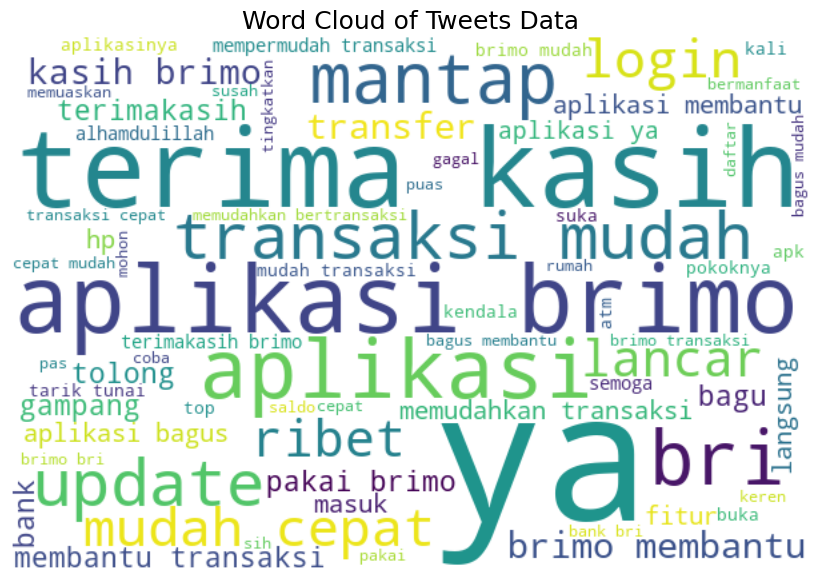

In [62]:
# Kode 31: Membuat Word Cloud Secara Umum

# Menggabungkan seluruh teks dari kolom 'text_StopWord'
# Mengisi nilai NaN dengan string kosong dan mengkonversi semua nilai ke string
all_text = ' '.join(df['text_StopWord'].fillna('').astype(str))

# Membuat word cloud dari teks yang telah digabungkan
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(all_text)

# Menampilkan word cloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()


# Membuat DataFrame untuk Word Cloud Positive

In [63]:
# Menampilkan kolom dengan lebar maksimum (opsional)
pd.set_option('display.max_colwidth', 3000)

# Buat DataFrame untuk tweet dengan label 'positive'
positive_tweets = df[df['polarity'] == 'positive']

# Pilih kolom yang relevan; sesuaikan dengan DataFrame Anda
# Di sini saya menggunakan 'text_String' (hasil gabungan token) dan 'text_StopWord' sebagai teks yang telah diproses
positive_tweets = positive_tweets[['text_String', 'polarity_score', 'polarity', 'text_StopWord']]

# Urutkan berdasarkan skor polaritas secara menurun (nilai tertinggi di atas)
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

# Untuk verifikasi, Anda dapat menampilkan beberapa baris dari positive_tweets
print(positive_tweets.head())


                                                                                                                                                                                                text_String  \
1        alhamdulillah guna pasilitas brimo cepat mudah jalan guna terima kasih brimo mudah mudah tahan butuh sulit guna kirim perlu butuh perlu terimakasih brimo yamudah mudah putus pasilitas kirim baru   
2                                                                                                                      alhamdulillah pakai brimo lancar kendala dana teman tolong dana dana dana teman dana   
3                                                                                                            dana akun brimo hasil dana kali dana baca mohon laku dana brimo kayak intrusi brimo mohon baik   
4                                                       good mudah bisnis gampang heran komentar negatif alhamdulillah lancar pakai mahal infinix alhamdulillah brimo lancar

# Menampilkan Word Cloud untuk Label Positive

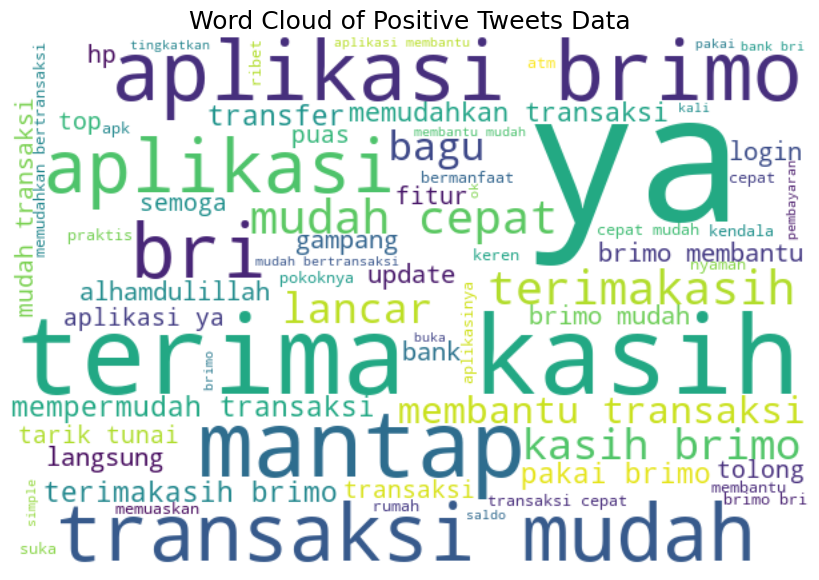

In [64]:
# Menggabungkan seluruh teks dari kolom 'text_StopWord' pada DataFrame positive_tweets
all_positive_text = ' '.join(positive_tweets['text_StopWord'].fillna('').astype(str))

# Membuat word cloud dari teks yang telah digabungkan
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(all_positive_text)

# Menampilkan word cloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()


# Membuat DataFrame untuk Word Cloud Negative

In [65]:
# Menampilkan kolom dengan lebar maksimum (opsional)
pd.set_option('display.max_colwidth', 3000)

# Ambil subset tweet dengan label 'negative'
negative_tweets = df[df['polarity'] == 'negative']

# Pilih kolom yang relevan; sesuaikan dengan nama kolom yang ada (misalnya 'text_String' dan 'text_StopWord')
negative_tweets = negative_tweets[['text_String', 'polarity_score', 'polarity', 'text_StopWord']]

# Urutkan berdasarkan skor polaritas secara menurun
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

# Tampilkan beberapa baris untuk verifikasi
print(negative_tweets.head())


                                                                                                            text_String  \
1  mohon info brimo akses download ulang link kirim user password info general error link valid mohon info terima kasih   
2                                                     aplikasi bermamfaat fiturnya lengkap saran kembang aplikasi berat   
3                                                                                 buka aplikasi tiba tolong kasih jelas   
4                                                                                                  aplikasi bagus bantu   
5                                                                                brimo kalah senang aplikasi bank keren   

   polarity_score  polarity  \
1              -7  negative   
2              -7  negative   
3              -7  negative   
4              -7  negative   
5              -7  negative   

                                                                          

# Menampilkan Word Cloud untuk Label Negative

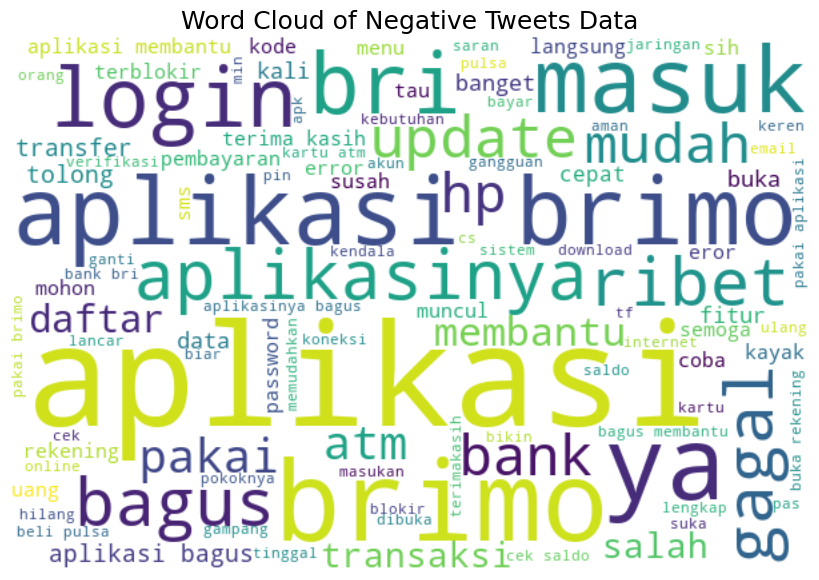

In [66]:
# Gabungkan seluruh teks dari kolom 'text_StopWord' pada DataFrame negative_tweets
all_negative_text = ' '.join(negative_tweets['text_StopWord'].fillna('').astype(str))

# Buat word cloud dari teks yang telah digabungkan
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(all_negative_text)

# Tampilkan word cloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()


# Membuat DataFrame untuk Word Cloud Neutral

In [67]:
# Menampilkan kolom dengan lebar maksimum (opsional)
pd.set_option('display.max_colwidth', 3000)

# Ambil subset tweet dengan label 'neutral'
neutral_tweets = df[df['polarity'] == 'neutral']

# Pilih kolom yang relevan, misalnya 'text_String' dan 'text_StopWord'
neutral_tweets = neutral_tweets[['text_String', 'polarity_score', 'polarity', 'text_StopWord']]

# Urutkan berdasarkan skor polaritas secara menurun
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

# Tampilkan beberapa baris untuk verifikasi
print(neutral_tweets.head())


                                                                                               text_String  \
1                                                                              aplikasi simole mudah paham   
2  tolong aplikasi transfer bank data simpan langsung pilih transfer bifast catat catat ulang terima kasih   
3                                                                                      layan lengkap cepat   
4                                                                                     gampang kirim hambat   
5                                                                                           aplikasi mudah   

   polarity_score polarity  \
1              -1  neutral   
2              -1  neutral   
3              -1  neutral   
4              -1  neutral   
5              -1  neutral   

                                                                                                     text_StopWord  
1                                        

# Menampilkan Word Cloud untuk Label Neutral

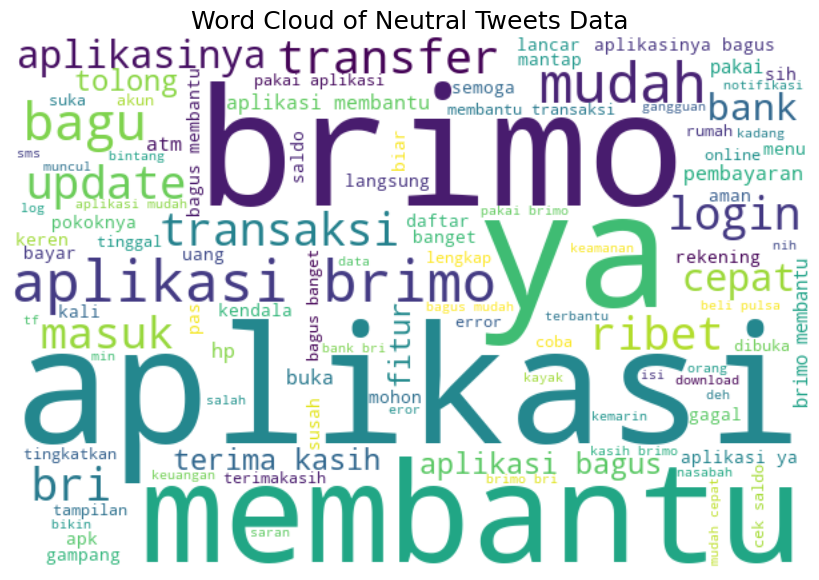

In [68]:
# Menggabungkan seluruh teks dari kolom 'text_StopWord' pada DataFrame neutral_tweets
all_neutral_text = ' '.join(neutral_tweets['text_StopWord'].fillna('').astype(str))

# Membuat word cloud dari teks yang telah digabungkan
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(all_neutral_text)

# Menampilkan word cloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Tweets Data', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()


# Menampilkan Distribusi Panjang Teks

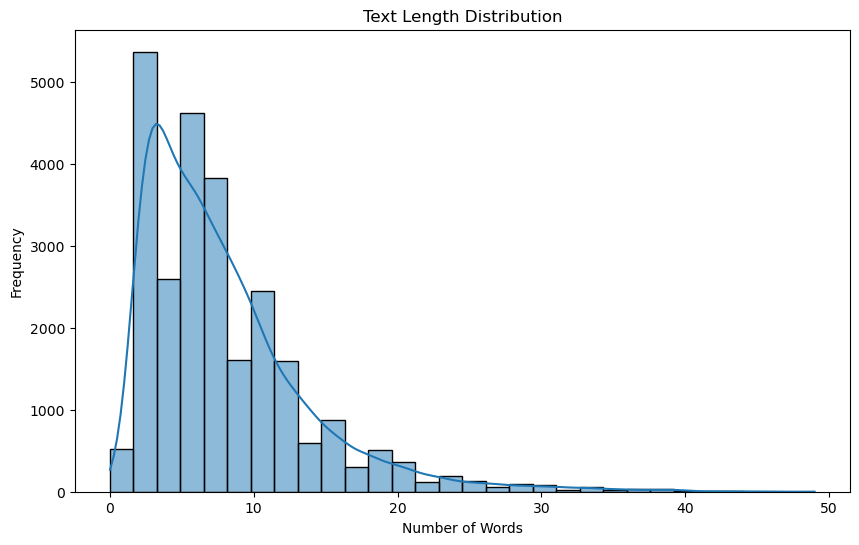

In [71]:
# Pastikan kolom 'text_String' tidak memiliki nilai NaN dan berupa string
df['text_String'] = df['text_String'].fillna('').astype(str)

# Set ukuran figure
plt.figure(figsize=(10, 6))

# Menghitung panjang teks berdasarkan jumlah kata pada kolom 'text_String'
df['text_length'] = df['text_String'].apply(lambda x: len(x.split()))

# Visualisasikan distribusi panjang teks
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


# Menampilkan Kata yang Paling Sering Muncul

C:\Users\Sion Pardosi\AppData\Local\Temp\ipykernel_45532\3411159645.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='jumlah', y='index', data=tfidf_top20, palette='viridis')


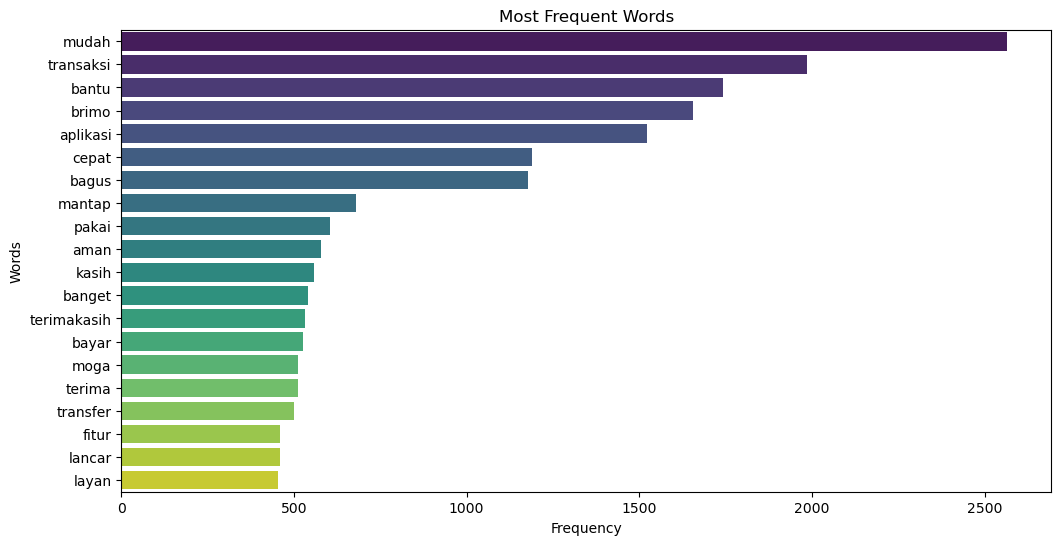

In [72]:
# Pastikan kolom 'text_String' sudah bersih dari NaN dan berupa string
df['text_String'] = df['text_String'].fillna('').astype(str)

# Set ukuran figure
plt.figure(figsize=(12, 6))

# Menggunakan TfidfVectorizer untuk menghitung frekuensi kata pada kolom 'text_String'
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_String'])

# Membuat DataFrame TF-IDF
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Menjumlahkan setiap kata di seluruh dokumen
tfidf_sum = tfidf_df.sum().reset_index(name='jumlah')

# Mengurutkan dan mengambil 20 kata dengan frekuensi tertinggi
tfidf_top20 = tfidf_sum.sort_values('jumlah', ascending=False).head(20)

# Menampilkan diagram batang
sns.barplot(x='jumlah', y='index', data=tfidf_top20, palette='viridis')
plt.title('Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


##

##

# MODELING


##

Pembuatan model dengan melakukan tiga percobaan skema pelatihan yang berbeda dan dibedakan dengan variasi dari dua kombinasi seperti berikut:

- Model 1
  - Algoritma Pelatihan: LSTM
  - Pembagian Data: Training 70, val 20, test 10
- Model 2
  - Algoritma Pelatihan: CNN
  - Pembagian Data: Training 80, val 10, test 10
- Model 3
  - Algoritma Pelatihan: GRU
  - Pembagian Data: Training 90, val 5, test 5

##

# Kolom text_akhir dijadikan sebagai fitur dan kolom polarity dijadikan sebagai target.

In [74]:
# Mengambil kolom fitur dan target
# Menggunakan kolom 'text_String' sebagai teks akhir yang sudah diproses
X = df['text_String']
y = df['polarity']

# Tampilkan 5 baris pertama untuk verifikasi
print(X.head())
print(y.head())

0                                                   login scan fingerprint muncul error transaksi gagal kode rzpo bugnya simpang banget login lupa pasword pasuk error data sesuai kode hsna normal sesuai update
1    brimo tawar mudah transaksi tampil intuitif akses cepat layan perban digital guna puas tantang sabar salah kendala utama batas login perangkat harus guna jaring batas guna fleksibilitas adaptasi teknologi
2                                                                             ganggu dikit update kasih update baik celah lemah aman akibat hack update tanda baik kerja team push tingkat ribet uras otak tenaga
3                                               tanggal maret update update muncul fitur nonaktif aksebilitas ikut sesuai tunjuk fitur muncul aplikasi brimo buka fitur atas muncul updatenya buruk aplikasi buka
4                                                         brimo error sinyal kuat stabil pengaruh cuaca tolong update biar cepat login sidik jari error transfer

# Melakukan tokenisasi.

Tokenizer: Menginisialisasi tokenizer dengan maksimal 2500 kata, kemudian mengubah teks pada X (yang merupakan kolom text_String) menjadi urutan angka dan menerapkan padding agar semua urutan memiliki panjang yang sama.

LabelEncoder & to_categorical: Mengubah label target (kolom polarity) ke bentuk integer dan selanjutnya ke one-hot encoded vector.

num_classes: Mendapatkan jumlah kelas dari bentuk one-hot encoded y.

In [75]:
# Tokenisasi
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)  # X berasal dari df['text_String']
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding untuk target y
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)  # y berasal dari df['polarity']
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

print("Shape of tokenized sequences:", X.shape)
print("Shape of target labels:", y.shape)
print("Number of classes:", num_classes)


Shape of tokenized sequences: (26060, 44)
Shape of target labels: (26060, 3)
Number of classes: 3


# Mendefinisikan callbacks yang akan berhenti jika nilai akurasi pelatihan > 0.95.

In [76]:
import tensorflow as tf

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Pastikan nilai accuracy tersedia dan jika lebih dari 0.95, hentikan pelatihan
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95:
            print(f"\nTraining accuracy telah melebihi 0.95, menghentikan pelatihan pada epoch {epoch+1}")
            self.model.stop_training = True

early_stopping = CustomCallback()


##

# Model 1 - LSTM

# Memisahkan Data Latih, Validasi, dan Uji

In [77]:
# Membagi dataset: 10% untuk uji, sisanya untuk train+validation
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)

# Dari train+validation, ambil 20% sebagai validation (total: 70% training, 20% validation, 10% testing)
X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

print("Shape X_train_LSTM:", X_train_LSTM.shape)
print("Shape X_val_LSTM:", X_val_LSTM.shape)
print("Shape X_test_LSTM:", X_test_LSTM.shape)


Shape X_train_LSTM: (18242, 44)
Shape X_val_LSTM: (5212, 44)
Shape X_test_LSTM: (2606, 44)


# Membangun Model LSTM

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model_LSTM.summary()


c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Melatih dan Mengevaluasi Model

In [79]:
# Melatih model dengan early stopping kustom (misalnya: berhenti jika akurasi training > 0.95)
batch_size = 2056
history_LSTM = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=50,
    batch_size=batch_size,
    verbose=2,
    callbacks=[early_stopping],
    validation_data=(X_val_LSTM, y_val_LSTM)
)

# Evaluasi model pada data uji
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print("Test score: %.2f" % score_LSTM)
print("Test accuracy: %.2f" % acc_LSTM)


Epoch 1/50
9/9 - 16s - 2s/step - accuracy: 0.7206 - loss: 5.3777 - val_accuracy: 0.7245 - val_loss: 4.6153
Epoch 2/50
9/9 - 10s - 1s/step - accuracy: 0.7213 - loss: 4.1563 - val_accuracy: 0.7245 - val_loss: 3.6052
Epoch 3/50
9/9 - 11s - 1s/step - accuracy: 0.7213 - loss: 3.2416 - val_accuracy: 0.7245 - val_loss: 2.8082
Epoch 4/50
9/9 - 10s - 1s/step - accuracy: 0.7214 - loss: 2.5305 - val_accuracy: 0.7281 - val_loss: 2.1938
Epoch 5/50
9/9 - 10s - 1s/step - accuracy: 0.7316 - loss: 1.9699 - val_accuracy: 0.7485 - val_loss: 1.6878
Epoch 6/50
9/9 - 10s - 1s/step - accuracy: 0.7540 - loss: 1.5209 - val_accuracy: 0.7748 - val_loss: 1.3155
Epoch 7/50
9/9 - 10s - 1s/step - accuracy: 0.7837 - loss: 1.1921 - val_accuracy: 0.8087 - val_loss: 1.0439
Epoch 8/50
9/9 - 10s - 1s/step - accuracy: 0.8084 - loss: 0.9509 - val_accuracy: 0.8317 - val_loss: 0.8358
Epoch 9/50
9/9 - 10s - 1s/step - accuracy: 0.8265 - loss: 0.7723 - val_accuracy: 0.8406 - val_loss: 0.6942
Epoch 10/50
9/9 - 10s - 1s/step - acc

In [80]:
# Evaluasi model pada data uji
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print("Test score: %.2f" % score_LSTM)
print("Test accuracy: %.2f" % acc_LSTM)

82/82 - 2s - 23ms/step - accuracy: 0.8576 - loss: 0.4233
Test score: 0.42
Test accuracy: 0.86


# Menyimpan Model

In [81]:
# Menyimpan model LSTM ke file
model_LSTM.save('D:\PROJECT\DBS DICODING\Belajar Pengembangan Machine Learning\sentimen\Proyek Analisis Sentimen\Model\model_LSTM.h5')

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Sion Pardosi\AppData\Local\Temp\ipykernel_45532\311233368.py:2: SyntaxWarning: invalid escape sequence '\P'
  model_LSTM.save('D:\PROJECT\DBS DICODING\Belajar Pengembangan Machine Learning\sentimen\Proyek Analisis Sentimen\Model\model_LSTM.h5')


##

 # Model 2 - CNN

# Memisahkan Data Latih, Validasi, dan Uji

In [82]:
# Memisahkan data latih, validasi, dan uji untuk model CNN
X_train_val, X_test_CNN, y_train_val, y_test_CNN = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

print("Shape X_train_CNN:", X_train_CNN.shape)
print("Shape X_val_CNN:", X_val_CNN.shape)
print("Shape X_test_CNN:", X_test_CNN.shape)


Shape X_train_CNN: (20848, 44)
Shape X_val_CNN: (2606, 44)
Shape X_test_CNN: (2606, 44)


# Membangun Model CNN

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Membangun model CNN
model_CNN = Sequential()
model_CNN.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_CNN.add(Conv1D(64, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_classes, activation='softmax'))

model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_CNN.summary()

# Melatih model dengan early stopping kustom
batch_size = 2056
history_CNN = model_CNN.fit(
    X_train_CNN, y_train_CNN,
    epochs=50,
    batch_size=batch_size,
    verbose=2,
    callbacks=[early_stopping],
    validation_data=(X_val_CNN, y_val_CNN)
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 - 11s - 995ms/step - accuracy: 0.6881 - loss: 0.8248 - val_accuracy: 0.7264 - val_loss: 0.7055
Epoch 2/50
11/11 - 6s - 539ms/step - accuracy: 0.7220 - loss: 0.6937 - val_accuracy: 0.7310 - val_loss: 0.5975
Epoch 3/50
11/11 - 7s - 616ms/step - accuracy: 0.7524 - loss: 0.5647 - val_accuracy: 0.7828 - val_loss: 0.4906
Epoch 4/50
11/11 - 6s - 551ms/step - accuracy: 0.7996 - loss: 0.4620 - val_accuracy: 0.8273 - val_loss: 0.4191
Epoch 5/50
11/11 - 6s - 544ms/step - accuracy: 0.8359 - loss: 0.3899 - val_accuracy: 0.8442 - val_loss: 0.3824
Epoch 6/50
11/11 - 6s - 538ms/step - accuracy: 0.8570 - loss: 0.3439 - val_accuracy: 0.8584 - val_loss: 0.3574
Epoch 7/50
11/11 - 6s - 571ms/step - accuracy: 0.8720 - loss: 0.3163 - val_accuracy: 0.8699 - val_loss: 0.3395
Epoch 8/50
11/11 - 6s - 534ms/step - accuracy: 0.8869 - loss: 0.2900 - val_accuracy: 0.8734 - val_loss: 0.3331
Epoch 9/50
11/11 - 6s - 576ms/step - accuracy: 0.8950 - loss: 0.2747 - val_accuracy: 0.8749 - val_loss: 0.3338


# Evaluasi Model CNN

In [84]:
# Evaluasi model CNN pada data uji
score_CNN, acc_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN, verbose=2, batch_size=1028)
print("Test score: %.2f" % score_CNN)
print("Test accuracy: %.2f" % acc_CNN)

3/3 - 0s - 102ms/step - accuracy: 0.8691 - loss: 0.4494
Test score: 0.45
Test accuracy: 0.87


# Menyimpan Model CNN

In [85]:
# Menyimpan model CNN
model_CNN.save('D:\PROJECT\DBS DICODING\Belajar Pengembangan Machine Learning\sentimen\Proyek Analisis Sentimen\Model\model_CNN.h5')

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Sion Pardosi\AppData\Local\Temp\ipykernel_45532\1883134718.py:2: SyntaxWarning: invalid escape sequence '\P'
  model_CNN.save('D:\PROJECT\DBS DICODING\Belajar Pengembangan Machine Learning\sentimen\Proyek Analisis Sentimen\Model\model_CNN.h5')


##

# Model 3 - GRU

# Memisahkan Data Latih, Validasi, dan Uji

In [86]:
# Memisahkan data latih, validasi, dan uji untuk model GRU
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=0.0526, random_state=42)

print("Shape X_train_GRU:", X_train_GRU.shape)
print("Shape X_val_GRU:", X_val_GRU.shape)
print("Shape X_test_GRU:", X_test_GRU.shape)


Shape X_train_GRU: (23454, 44)
Shape X_val_GRU: (1303, 44)
Shape X_test_GRU: (1303, 44)


# Membangun Model GRU

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Membangun model GRU
model_GRU = Sequential()
model_GRU.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(Bidirectional(GRU(64, return_sequences=True)))
model_GRU.add(Bidirectional(GRU(128, return_sequences=False)))
model_GRU.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(num_classes, activation='softmax'))

model_GRU.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_GRU.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Melatih dan Mengevaluasi Model GRU

In [88]:
batch_size = 1028
history_GRU = model_GRU.fit(
    X_train_GRU, y_train_GRU,
    epochs=20,
    batch_size=batch_size,
    verbose=2,
    validation_data=(X_val_GRU, y_val_GRU),
    callbacks=[early_stopping]
)

# Evaluasi model GRU pada data uji
score_GRU, acc_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=2)
print("Test score: %.2f" % score_GRU)
print("Test accuracy: %.2f" % acc_GRU)


Epoch 1/20
23/23 - 54s - 2s/step - accuracy: 0.6604 - loss: 2.8974 - val_accuracy: 0.7352 - val_loss: 2.2028
Epoch 2/20
23/23 - 29s - 1s/step - accuracy: 0.7574 - loss: 1.8315 - val_accuracy: 0.8189 - val_loss: 1.3820
Epoch 3/20
23/23 - 28s - 1s/step - accuracy: 0.8399 - loss: 1.1658 - val_accuracy: 0.8741 - val_loss: 0.9178
Epoch 4/20
23/23 - 27s - 1s/step - accuracy: 0.8676 - loss: 0.8002 - val_accuracy: 0.8764 - val_loss: 0.6751
Epoch 5/20
23/23 - 27s - 1s/step - accuracy: 0.8862 - loss: 0.5887 - val_accuracy: 0.8826 - val_loss: 0.5294
Epoch 6/20
23/23 - 28s - 1s/step - accuracy: 0.9012 - loss: 0.4609 - val_accuracy: 0.8718 - val_loss: 0.4577
Epoch 7/20
23/23 - 29s - 1s/step - accuracy: 0.9053 - loss: 0.3864 - val_accuracy: 0.8734 - val_loss: 0.4066
Epoch 8/20
23/23 - 28s - 1s/step - accuracy: 0.9079 - loss: 0.3392 - val_accuracy: 0.8772 - val_loss: 0.3920
Epoch 9/20
23/23 - 28s - 1s/step - accuracy: 0.9146 - loss: 0.3033 - val_accuracy: 0.8772 - val_loss: 0.3701
Epoch 10/20
23/23 -

In [89]:
# Evaluasi model GRU pada data uji
score_GRU, acc_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=2)
print("Test score: %.2f" % score_GRU)
print("Test accuracy: %.2f" % acc_GRU)

41/41 - 1s - 22ms/step - accuracy: 0.8649 - loss: 0.4071
Test score: 0.41
Test accuracy: 0.86


# Menyimpan Model GRU

In [90]:
# Menyimpan model GRU ke file
model_GRU.save('D:\PROJECT\DBS DICODING\Belajar Pengembangan Machine Learning\sentimen\Proyek Analisis Sentimen\Model\model_GRU.h5')

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Sion Pardosi\AppData\Local\Temp\ipykernel_45532\612689854.py:2: SyntaxWarning: invalid escape sequence '\P'
  model_GRU.save('D:\PROJECT\DBS DICODING\Belajar Pengembangan Machine Learning\sentimen\Proyek Analisis Sentimen\Model\model_GRU.h5')


##

# Evaluasi Keseluruhan Model

### Menyusun Hasil Evaluasi Model

In [91]:
results_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN', 'GRU'],
    'Accuracy Train': [
        history_LSTM.history['accuracy'][-1],
        history_CNN.history['accuracy'][-1],
        history_GRU.history['accuracy'][-1]
    ],
    'Accuracy Test': [acc_LSTM, acc_CNN, acc_GRU]
})
print(results_df)


  Model  Accuracy Train  Accuracy Test
0  LSTM        0.922870       0.857636
1   CNN        0.953617       0.869148
2   GRU        0.943421       0.864927


### Visualisasi Perbandingan Akurasi Model

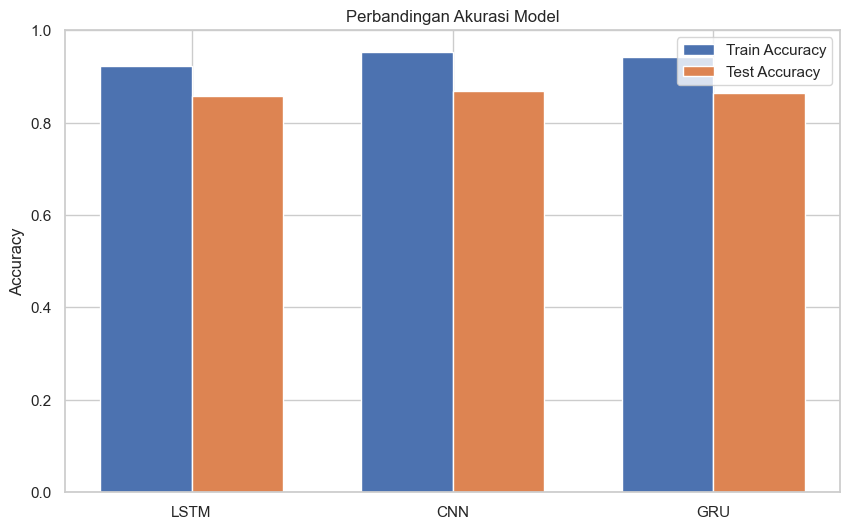

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Mengambil data dari results_df
models = results_df['Model']
train_acc = results_df['Accuracy Train']
test_acc = results_df['Accuracy Test']

x_indices = range(len(models))
width = 0.35

plt.bar([i - width/2 for i in x_indices], train_acc, width=width, label='Train Accuracy')
plt.bar([i + width/2 for i in x_indices], test_acc, width=width, label='Test Accuracy')
plt.xticks(x_indices, models)
plt.ylabel('Accuracy')
plt.title('Perbandingan Akurasi Model')
plt.legend()
plt.show()


##

# Predict – Memprediksi Label pada Data Baru

In [132]:
# Contoh data baru
new_texts = [
    "keren dan menyenangkan",
    "Sayangnya, aplikasi BRImo sering mengalami error dan loading yang lama, tidak bisa login",
    "belum optimal tetapi lumayan bagus"
]

# Nilai asli dari teks
true_labels = ["positive", "negative", "neutral"]

# Tokenisasi dan padding untuk data baru
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=X.shape[1])

# Membuat prediksi menggunakan ketiga model
predictions_LSTM = model_LSTM.predict(new_padded_sequences)
predictions_CNN = model_CNN.predict(new_padded_sequences)
predictions_GRU = model_GRU.predict(new_padded_sequences)

# Mengubah prediksi ke label (menggunakan argmax)
predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)
predicted_labels_CNN = np.argmax(predictions_CNN, axis=1)
predicted_labels_GRU = np.argmax(predictions_GRU, axis=1)

# Mengonversi label integer ke label asli menggunakan labelencoder
predicted_labels_LSTM = labelencoder.inverse_transform(predicted_labels_LSTM)
predicted_labels_CNN = labelencoder.inverse_transform(predicted_labels_CNN)
predicted_labels_GRU = labelencoder.inverse_transform(predicted_labels_GRU)

# Menampilkan hasil prediksi
for text, true_label, label_LSTM, label_CNN, label_GRU in zip(new_texts, true_labels, predicted_labels_LSTM, predicted_labels_CNN, predicted_labels_GRU):
    print(f"Text: {text}\nTrue Label: {true_label}\nPredicted Label (LSTM): {label_LSTM}\nPredicted Label (CNN): {label_CNN}\nPredicted Label (GRU): {label_GRU}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Text: keren dan menyenangkan
True Label: positive
Predicted Label (LSTM): positive
Predicted Label (CNN): positive
Predicted Label (GRU): positive

Text: Sayangnya, aplikasi BRImo sering mengalami error dan loading yang lama, tidak bisa login
True Label: negative
Predicted Label (LSTM): negative
Predicted Label (CNN): negative
Predicted Label (GRU): negative

Text: belum optimal tetapi lumayan bagus
True Label: neutral
Predicted Label (LSTM): neutral
Predicted Label (CNN): neutral
Predicted Label (GRU): neutral

